See the [explanatory blog post](http://www.columbia.edu/~ahd2125/technical/2015/06/08/permutation-tests.html)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from collections import defaultdict
import glob

import networkx as nx
from chess import pgn


g = nx.DiGraph()
global_stats = defaultdict(lambda : defaultdict(int))

for fname in glob.glob("data/*.pgn"):
    with open(fname) as fin:
        for __, header in pgn.scan_headers(fin):
            w = header["White"].split(",")[0]
            b = header["Black"].split(",")[0]
            if not g.has_edge(w, b):
                g.add_edge(w, b, win=0, loss=0, draw=0)
            if not g.has_edge(b, w):
                g.add_edge(b, w, win=0, loss=0, draw=0)
            
            # g[w][b]["loss"] is # of losses w has against l.
            if header["Result"] == "0-1":
                g[w][b]["loss"] += 1
                g[b][w]["win"] += 1
                global_stats[b]["win"] += 1
                global_stats[w]["loss"] += 1
            elif header["Result"] == "1-0":
                g[w][b]["win"] += 1
                g[b][w]["loss"] += 1
                global_stats[w]["win"] += 1
                global_stats[b]["loss"] += 1
            elif header["Result"] == "1/2-1/2":
                g[w][b]["draw"] += 1
                g[b][w]["draw"] += 1
                global_stats[w]["draw"] += 1
                global_stats[b]["draw"] += 1
            else:
                print(header["Result"])

In [3]:
def points(stats):   # approximate win percentage by weighting draws
    num_games = stats["win"] + stats["loss"] + stats["draw"]
    return (stats["win"] + 0.5 * stats["draw"]) / num_games

In [4]:
for w, b in g.edges_iter():
    g[w][b]["weight"] = points(g[w][b])

In [5]:
global_scores = pd.Series({player: points(record) for player, record in global_stats.items()})

In [6]:
scores = pd.DataFrame({player: {against: points(record) for against, record in edge.items()} 
                         for player, edge in g.edge.items()})

In [7]:
# scores["Adams"] represents  Adam's win percentage against everyone else.
adams_ranking = scores["Adams"].dropna()
adams_ranking1 = pd.Series({player: points(record) for player, record in g.edge["Adams"].items()})

assert (adams_ranking == adams_ranking1).all()

In [8]:
rank_diff = pd.DataFrame(index=scores.index)
for column in scores:
    local_scores = scores[column].dropna()
    rank_diff[column] = global_scores[local_scores.index].rank() - local_scores.rank()

# rank_diff["Adams"]["Anand"] represents how "especially" well Adams played against Anand    
rank_diff

,Adams,Anand,Aronian,Bacrot,Bartel,Bologan,Carlsen,Caruana,Dominguez Perez,Fridman,...,Ponomariov,Radjabov,Svidler,Tomashevsky,Topalov,Vallejo Pons,Van Wely,Vitiugov,Wang,Wang Hao
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.0,NaN,...,NaN,NaN,NaN,NaN,-5.0,NaN,NaN,NaN,NaN,-4.0
Anand,NaN,NaN,-1.0,NaN,NaN,NaN,-5.5,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-3.5,NaN,NaN,NaN,NaN
Aronian,NaN,0.0,NaN,NaN,NaN,NaN,7.5,23.0,NaN,NaN,...,NaN,9.0,NaN,0.5,5.5,-1.0,2.5,NaN,NaN,NaN
Bacrot,NaN,NaN,NaN,NaN,NaN,-3.5,-4.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.0,NaN
Bartel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-26.5,NaN,-4.0,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bologan,NaN,NaN,NaN,-3.5,NaN,NaN,-19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.5,NaN
Carlsen,NaN,4.0,16.0,1.5,NaN,3.0,NaN,29.0,NaN,NaN,...,NaN,17.0,NaN,3.0,17.5,4.0,5.0,NaN,14.5,NaN
Caruana,NaN,0.0,4.0,NaN,4.5,NaN,6.5,NaN,13.0,6.5,...,1.0,9.0,3,4.5,14.0,1.0,2.5,3.5,0.0,NaN
Dominguez Perez,-5.5,NaN,NaN,NaN,NaN,NaN,NaN,-21.5,NaN,NaN,...,-12.5,NaN,-5,NaN,-16.5,NaN,NaN,NaN,-3.5,-5.0
Fridman,NaN,NaN,NaN,NaN,-5.5,NaN,NaN,-20.0,NaN,NaN,...,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


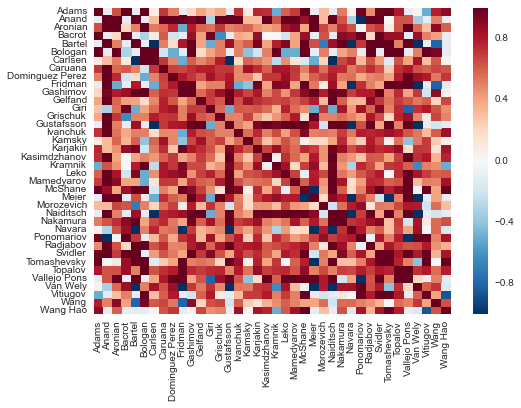

In [9]:
sns.heatmap(rank_diff.corr("spearman"))

In [10]:
import bottleneck
def rho_sum(df):
    return bottleneck.nansum(df.corr(method="spearman") ** 2)
ρ = rho_sum(rank_diff)
ρ

664.1192117288016

In [11]:
d = rank_diff.as_matrix().copy()

import numba

@numba.jit(nopython=True)
def permute(d):
    for col in range(d.shape[1]):
        np.random.shuffle(d[:, col])   # permute each columns
    return d

(array([   1.,    2.,    3.,    3.,    2.,    2.,    1.,    4.,    6.,
           4.,    7.,    8.,    5.,    7.,   14.,   12.,   19.,   27.,
          34.,   29.,   40.,   46.,   60.,   52.,   63.,   86.,  106.,
         120.,  107.,  127.,  156.,  174.,  174.,  163.,  181.,  210.,
         217.,  226.,  262.,  279.,  280.,  264.,  268.,  315.,  294.,
         281.,  275.,  297.,  302.,  288.,  283.,  286.,  280.,  271.,
         230.,  242.,  241.,  211.,  214.,  190.,  171.,  172.,  139.,
         157.,  126.,  112.,  118.,   77.,   81.,   61.,   64.,   67.,
          46.,   38.,   33.,   31.,   26.,   28.,   17.,   17.,   14.,
           7.,    8.,    6.,    7.,    5.,    3.,    3.,    2.,    4.,
           2.,    0.,    2.,    3.,    0.,    0.,    0.,    1.,    0.,    1.]),
 array([ 368.30723826,  369.54025975,  370.77328124,  372.00630272,
         373.23932421,  374.4723457 ,  375.70536719,  376.93838868,
         378.17141016,  379.40443165,  380.63745314,  381.87047463,
      

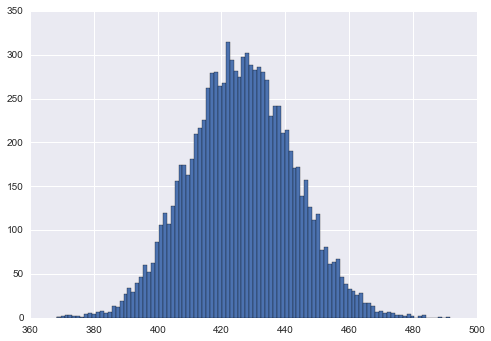

In [12]:
count = 10 ** 4
np.random.seed(42)
t = np.fromiter((rho_sum(pd.DataFrame(permute(d))) for i in range(count)), 
                dtype=np.float64, count=count)
plt.hist(t, bins=np.round(np.sqrt(count)))